<a href="https://colab.research.google.com/github/varun-beep/DeepLearning/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [2]:
# Enable mixed precision to reduce memory usage
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [3]:
# Clear memory before execution
tf.keras.backend.clear_session()
gc.collect()

0

In [4]:
# 1. Load dataset (Using CIFAR-10 for simplicity)
dataset = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = dataset.load_data()

In [5]:
# Reduce dataset size to avoid crashes
x_train, y_train = x_train[:5000], y_train[:5000]
x_test, y_test = x_test[:1000], y_test[:1000]

In [6]:
# 2. Preprocess images with further reduced size for lower memory usage
IMG_SIZE = 64  # Reduced from 96
batch_size = 4  # Lowered batch size to prevent crashes
epochs = 5  # Prevent excessive memory use

In [7]:
# Normalize pixel values and use tf.data.Dataset for efficiency
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    label = tf.keras.utils.to_categorical(label, 10)
    return image, label

train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                 .map(preprocess)
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE))

test_dataset = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                .map(preprocess)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))

In [8]:
# 3. Load VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze convolutional layers

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# 4. Add custom fully connected layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)  # Reduced neurons from 256 to 128
x = Dropout(0.4)(x)  # Adjusted dropout
y_pred = Dense(10, activation='softmax', dtype='float32')(x)  # Ensure proper dtype for mixed precision
model = Model(inputs=base_model.input, outputs=y_pred)

In [11]:
# Fix label shape issue
def fix_labels(dataset):
    def reshape_labels(image, label):
        return image, tf.reshape(label, [-1])  # Ensures labels are rank 1
    return dataset.map(reshape_labels)

# Apply the fix to datasets
train_dataset = fix_labels(train_dataset)
test_dataset = fix_labels(test_dataset)

# Debugging: Check shape before training
for images, labels in train_dataset.take(1):
    print("Fixed Image batch shape:", images.shape)
    print("Fixed Label batch shape:", labels.shape)

Fixed Image batch shape: (4, 64, 64, 3)
Fixed Label batch shape: (40,)


In [15]:
# Ensure labels are properly shaped
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    label = tf.squeeze(tf.one_hot(label, depth=10))  # Remove extra dimension
    return image, label

# Reapply preprocessing
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                 .map(preprocess)
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE))

test_dataset = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                .map(preprocess)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))

# Debugging: Check shape before training
for images, labels in train_dataset.take(1):
    print("Fixed Image batch shape:", images.shape)
    print("Fixed Label batch shape:", labels.shape)  # Should be (None, 10)


Fixed Image batch shape: (4, 64, 64, 3)
Fixed Label batch shape: (4, 10)


In [16]:
# 5. Compile and train model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.2443 - loss: 2.1480 - val_accuracy: 0.4840 - val_loss: 1.5571
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4583 - loss: 1.5431 - val_accuracy: 0.5370 - val_loss: 1.3890
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5425 - loss: 1.3465 - val_accuracy: 0.5680 - val_loss: 1.2925
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5999 - loss: 1.2265 - val_accuracy: 0.5770 - val_loss: 1.2325
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6074 - loss: 1.1422 - val_accuracy: 0.5980 - val_loss: 1.1985


In [17]:
# Debug: Check shapes before training
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Image batch shape: (4, 64, 64, 3)
Label batch shape: (4, 10)
Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6371 - loss: 1.0731 - val_accuracy: 0.5910 - val_loss: 1.1854
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6571 - loss: 1.0150 - val_accuracy: 0.5950 - val_loss: 1.1595
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6781 - loss: 0.9544 - val_accuracy: 0.6010 - val_loss: 1.1522
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6805 - loss: 0.9282 - val_accuracy: 0.6030 - val_loss: 1.1183
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7026 - loss: 0.8780 - val_accuracy: 0.6010 - val_loss: 1.1255


In [18]:
# 6. Evaluate model
loss, acc = model.evaluate(test_dataset)
y_pred = np.argmax(model.predict(tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE)) / 255.0), axis=1)
y_true = np.argmax(tf.keras.utils.to_categorical(y_test, 10), axis=1)

print("Test Accuracy:", acc)
print(classification_report(y_true, y_pred))

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5939 - loss: 1.1244
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step
Test Accuracy: 0.6010000109672546
              precision    recall  f1-score   support

           0       0.61      0.60      0.60       103
           1       0.68      0.71      0.69        89
           2       0.66      0.35      0.46       100
           3       0.44      0.42      0.43       103
           4       0.65      0.49      0.56        90
           5       0.35      0.53      0.43        86
           6       0.57      0.73      0.64       112
           7       0.78      0.68      0.72       102
           8       0.66      0.84      0.74       106
           9       0.76      0.62      0.68       109

    accuracy                           0.60      1000
   macro avg       0.62      0.60      0.60      1000
weighted avg       0.62      0.60      0.60      1000



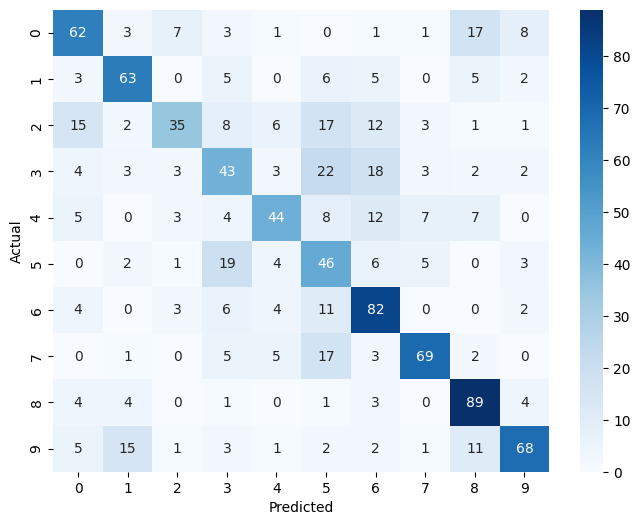

In [19]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 7. Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    rescale=1./255  # Normalize images
)

# Ensure images are resized before feeding into the generator
def preprocess_for_generator(images, labels):
    images_resized = tf.image.resize(images, (64, 64))  # Resize to 64x64
    return images_resized.numpy(), tf.keras.utils.to_categorical(labels, 10)  # Convert labels to one-hot

x_train_resized, y_train_resized = preprocess_for_generator(x_train, y_train)

# Apply Data Augmentation
train_generator = data_gen.flow(x_train_resized[:2000], y_train_resized[:2000], batch_size=batch_size)

# Model Training
model.fit(train_generator, validation_data=test_dataset, epochs=epochs)


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6432 - loss: 1.0470 - val_accuracy: 0.6240 - val_loss: 1.0981
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6519 - loss: 1.0141 - val_accuracy: 0.6310 - val_loss: 1.0884
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6541 - loss: 0.9936 - val_accuracy: 0.6150 - val_loss: 1.0927
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6826 - loss: 0.9868 - val_accuracy: 0.6110 - val_loss: 1.0971
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6532 - loss: 0.9826 - val_accuracy: 0.6220 - val_loss: 1.0893


In [22]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Low learning rate for stable training
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,  # Augmented dataset
    validation_data=test_dataset,  # Unseen test data
    epochs=epochs
)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6938 - loss: 0.9387 - val_accuracy: 0.6280 - val_loss: 1.0982
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6847 - loss: 0.9338 - val_accuracy: 0.6180 - val_loss: 1.1060
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6758 - loss: 0.9359 - val_accuracy: 0.6320 - val_loss: 1.0850
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6637 - loss: 0.9372 - val_accuracy: 0.6250 - val_loss: 1.0862
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6938 - loss: 0.8855 - val_accuracy: 0.6240 - val_loss: 1.0916


In [23]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6183 - loss: 1.0962
Test Accuracy: 62.40%


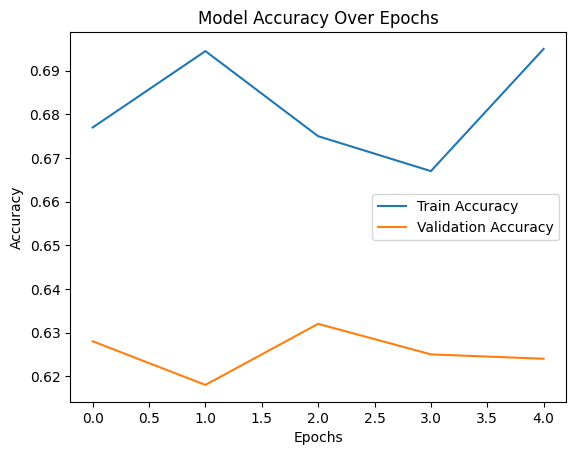

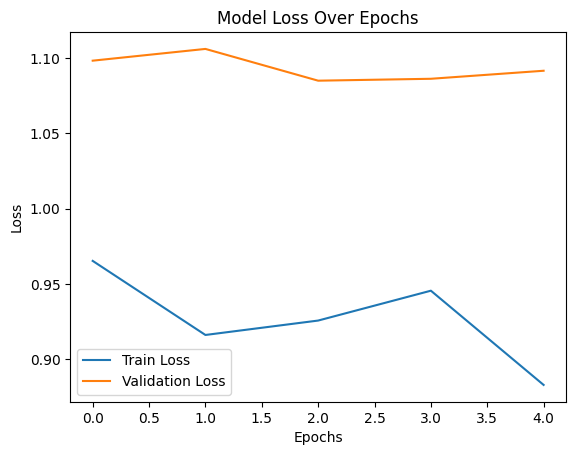

In [24]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()

# Plot Training & Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


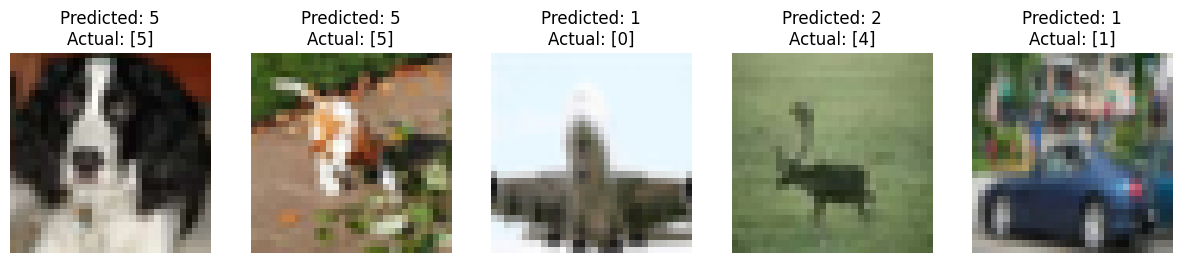

In [25]:
import numpy as np

# Select random test images
num_samples = 5
random_indices = np.random.choice(len(x_test), num_samples)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

# Resize images to 64x64 if needed
sample_images_resized = tf.image.resize(sample_images, (64, 64))

# Make predictions
predictions = model.predict(sample_images_resized)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Display results
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i])
    ax.set_title(f"Predicted: {predicted_labels[i]}\nActual: {sample_labels[i]}")
    ax.axis('off')
plt.show()

In [26]:
# Save the trained model
model.save('image_classifier_model.h5')

# Load the model later for inference
from tensorflow.keras.models import load_model
loaded_model = load_model('image_classifier_model.h5')

# Verify by evaluating again
loaded_model.evaluate(test_dataset)

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6183 - loss: 1.0962


[1.0915518999099731, 0.6240000128746033]